# Импорт библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 32.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
import rdkit
import torch

# Проверяем версии для уверенности в правильности установки
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("RDKit version:", rdkit.__version__)
print("PyTotch version:", torch.__version__)

TensorFlow version: 2.17.1
Keras version: 3.5.0
RDKit version: 2024.03.6
PyTotch version: 2.5.1+cu121


In [ ]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [ ]:
#импортируем методы RDKit
import warnings

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem, PandasTools, MACCSkeys, AtomPairs, rdFingerprintGenerator, rdMolDescriptors
from rdkit import DataStructs
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.AtomPairs.Pairs import GetAtomPairFingerprintAsBitVect

pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

#Создание нового основного датасета

Здесь будут молекулы-гости точно для WP6 с ацетат-радикалами

### Создадим функцию канонизации SMILES

In [ ]:
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    canonical_smiles = Chem.MolToSmiles(mol)
    return canonical_smiles

## Данные из основной статьи

In [ ]:
#Загружаем SMILES гостей
guests_smiles1 = pd.read_csv("/content/drive/MyDrive/host_guest/WP6/guest_files/WP6_guest_smiles.txt", sep=" ", header=None)
#канонизируем SMILES
guests_smiles1.columns = ["Smiles"]
guests_smiles1['Smiles'] = guests_smiles1['Smiles'].str.split(';').str.get(0)
#загружаем названия гостей
guests_names1 = pd.read_csv("/content/drive/MyDrive/host_guest/WP6/guest_files/WP6_guest_names.txt" ,sep=" ", header=None)
guests_names1.columns = ["Name"]
guests_names1['Name'] = guests_names1['Name'].map(lambda x: x.rstrip('G123456789;'))
guests1 = pd.concat([guests_names1, guests_smiles1], axis = 1)
#Загружаем константы
mean_const1 = [52000.0, 45000000.0 , 640000.0 , 500000.0 , 9200.0 , 720000.0 , 130000.0 , 23300.0, 37000.0 , 16000000.0 , 33000.0 , 89000000.0, 1600000.0]
part1 = guests1.assign(Ka_mean = mean_const1)
part1

,Name,Smiles,Ka_mean
0,cyclododecylammonium,[NH3+]C1CCCCCCCCCCC1,52000.0
1,"4-(1,1-dimethylpiperidin-1-ium-4-yl)-1,1-dimet...",C[N+]1(C)CCC(CC1)C1CC[N+](C)(C)CC1,45000000.0
2,norbornan-2-ylammonium,[NH3+]C1CC2CCC1C2,640000.0
3,trimethylsilylmethylammonium,C[Si](C)(C)C[NH3+],500000.0
4,"[3,5-dimethyl-7-(trimethylammonio)-1-adamantyl...",CC12CC3(C)CC(C1)(CC(C2)(C3)[N+](C)(C)C)[N+](C)...,9200.0
5,cyclooctylammonium,[NH3+]C1CCCCCCC1,720000.0
6,cyclohexylammonium,[NH3+]C1CCCCC1,130000.0
7,3-[benzyl(dimethyl)ammonio]propane-1-sulfonate,C[N+](C)(CCCS([O-])(=O)=O)CC1=CC=CC=C1,23300.0
8,(3-hydroxy-1-adamantyl)ammonium,[NH3+]C12CC3CC(C1)CC(O)(C3)C2,37000.0
9,trimethyl-[[4-[(trimethylammonio)methyl]phenyl...,C[N+](C)(C)CC1=CC=C(C[N+](C)(C)C)C=C1,16000000.0


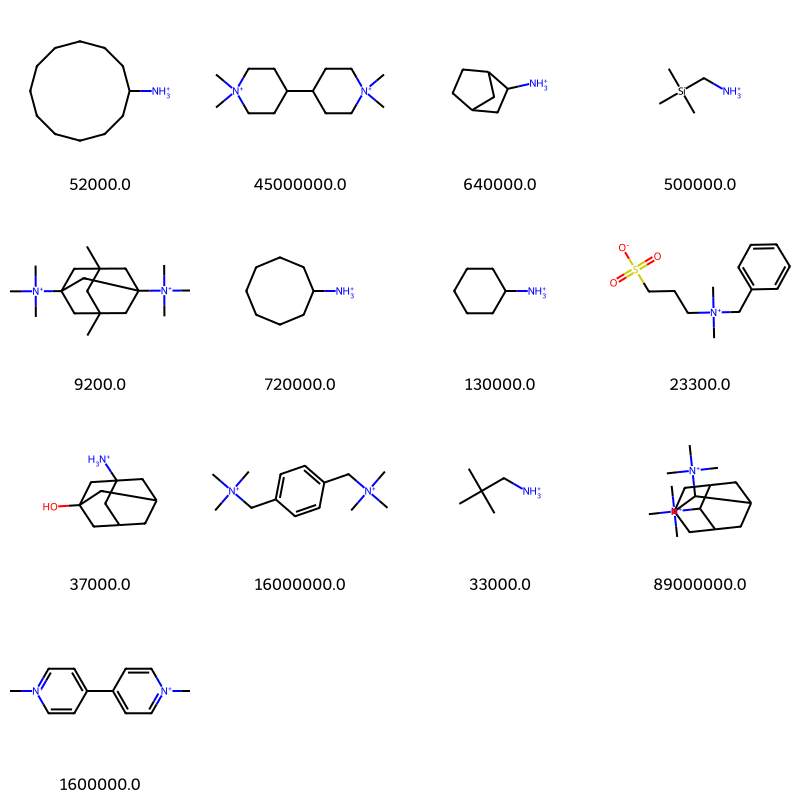

In [ ]:
#Визуализируем датасет
legends = [str(k) for k in part1["Ka_mean"]]

Draw.MolsToGridImage(
    [Chem.MolFromSmiles(s) for s in part1["Smiles"]],
    molsPerRow=4,
    subImgSize=(200, 200),
    legends=legends
)

## Новые данные [из второй статьи](https://www.sciencedirect.com/science/article/pii/S1386142521000317?via%3Dihub)

In [ ]:
guests_smiles2 = ["[O-]C(C=CC1/C=C/C(=CC=[N+]2C)C=C2)=CC=1",
                  "[O-]C(C=CC1/C=C/C(=CC=[N+]2C(C=CC3)=CC=3)C=C2)=CC=1",
                  "[O-]C(=C(Br)C=C1/C=C/C(C=C[N+]2C(C=CC3)=CC=3)=CC=2)C(Br)=C1"]
guests_names2 = ["4-(2-(1-phenylpyridin-1-ium-4-yl)vinyl)methilate",
                 "4-(2-(1-phenylpyridin-1-ium-4-yl)vinyl)phenolate",
                 "2,6-dibromo-4-(2-(1-phenylpyridin-1-ium-4-yl)vinyl)phenolate"]
mean_const2 = [1.24e5,
               4.9e6,
               1.05e5]
canon_smiles2 = [canonicalize_smiles(smiles) for smiles in guests_smiles2]

data2 = {"Name": guests_names2,
         "Smiles": canon_smiles2,
         "Ka_mean": mean_const2}
part2 = pd.DataFrame(data2)
part2

,Name,Smiles,Ka_mean
0,4-(2-(1-phenylpyridin-1-ium-4-yl)vinyl)methilate,C[n+]1ccc(/C=C/c2ccc([O-])cc2)cc1,124000.0
1,4-(2-(1-phenylpyridin-1-ium-4-yl)vinyl)phenolate,[O-]c1ccc(/C=C/c2cc[n+](-c3ccccc3)cc2)cc1,4900000.0
2,"2,6-dibromo-4-(2-(1-phenylpyridin-1-ium-4-yl)v...",[O-]c1c(Br)cc(/C=C/c2cc[n+](-c3ccccc3)cc2)cc1Br,105000.0


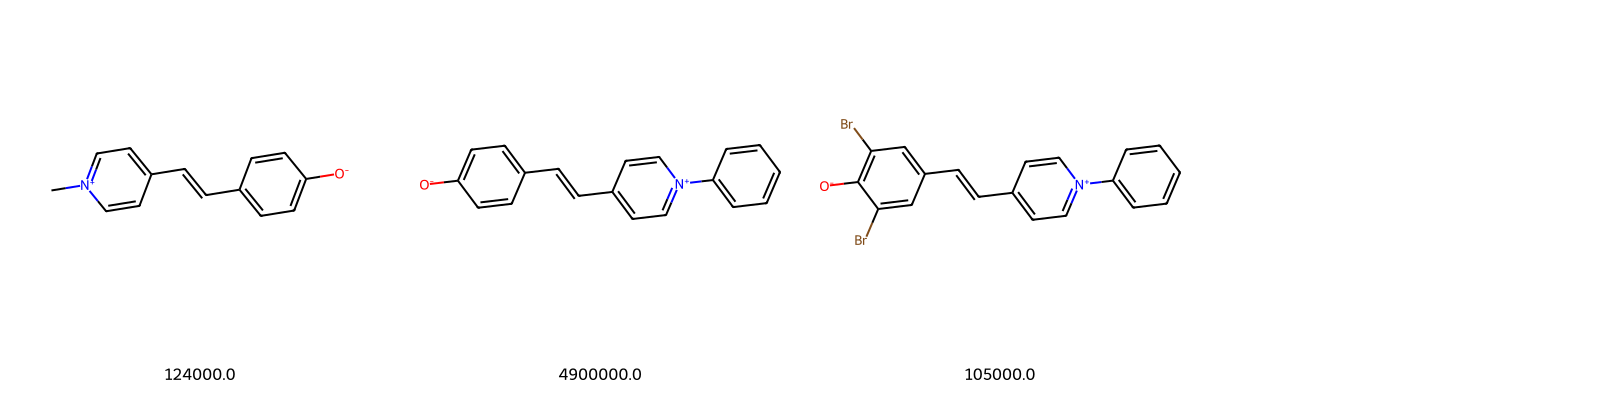

In [ ]:
#Визуализируем датасет
legends = [str(k) for k in part2["Ka_mean"]]

Draw.MolsToGridImage(
    [Chem.MolFromSmiles(s) for s in part2["Smiles"]],
    molsPerRow=4,
    subImgSize=(400, 400),
    legends=legends
)

## Новые данные из [ревью](https://www.researchgate.net/publication/273902408_Synthesis_of_Pillar6arenes_and_Their_Host-Guest_Complexes)

In [ ]:
guests_smiles3 = ["CCCCCCCCCCC[N+](=CC=C1)C=C1",
                  "CCCCCCCCCCCCCCCCC[N+](=CC=C1)C=C1",
                  "C[N+](=CC=C1C(CC)CC)C=C1",
                  "C[N+](C=CC1C(=CC=[N+]2C)C=C2)=CC=1",
                  "CC(C=C(C1)OCCCCCCCCCCOCC(C=C2)=C(C=C3)C(=C2C=C2)C(=C3CC3)C2C=3)=CC=1C"]
guests_names3 = ["1-undecylpyridin-1-ium",
                 "1-heptadecylpyridin-1-ium",
                 "1-methyl-4-pentan-3-ylpyridin-1-ium",
                 "1-methyl-4-(1-methylpyridin-1-ium-4-yl)pyridin-1-ium",
                 "None"]
mean_const3 = [1.24e5, 3.26e5, 1.67e5, 1.02e8, 8.04e4]

canon_smiles3 = [canonicalize_smiles(smiles) for smiles in guests_smiles3]

data3 = {"Name": guests_names3,
         "Smiles": canon_smiles3,
         "Ka_mean": mean_const3}

part3 = pd.DataFrame(data3)
part3

,Name,Smiles,Ka_mean
0,1-undecylpyridin-1-ium,CCCCCCCCCCC[n+]1ccccc1,124000.0
1,1-heptadecylpyridin-1-ium,CCCCCCCCCCCCCCCCC[n+]1ccccc1,326000.0
2,1-methyl-4-pentan-3-ylpyridin-1-ium,CCC(CC)c1cc[n+](C)cc1,167000.0
3,1-methyl-4-(1-methylpyridin-1-ium-4-yl)pyridin...,C[n+]1ccc(-c2cc[n+](C)cc2)cc1,102000000.0
4,None,Cc1cc(C)cc(OCCCCCCCCCCOCc2ccc3c4c5c(ccc24)CC=C...,80400.0


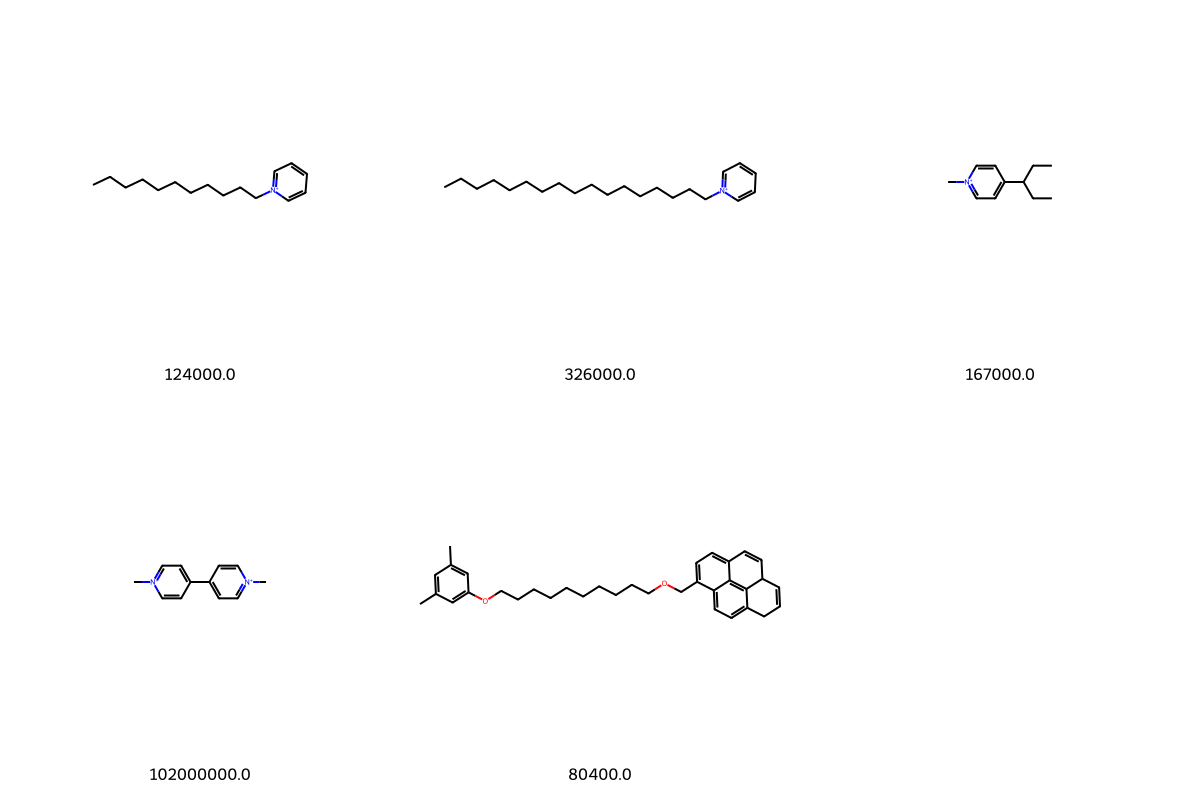

In [ ]:
#Визуализируем датасет
legends = [str(k) for k in part3["Ka_mean"]]

Draw.MolsToGridImage(
    [Chem.MolFromSmiles(s) for s in part3["Smiles"]],
    molsPerRow=3,
    subImgSize=(400, 400),
    legends=legends
)

# Дополнительный датасет с таргетами для подобных WP6 хозяев

## Похожие на основного хозяина молекулы: [того же ревью](https://www.researchgate.net/publication/273902408_Synthesis_of_Pillar6arenes_and_Their_Host-Guest_Complexes)

In [ ]:
guests_smiles_add = ["C[N+](C)(C)CCCCCCCC",
                  "CCCCCCCC[N+](CC)(CC)CC",
                  "N(=NC(=C/C=C1)C=C1)C(=C\C=C1)C=C1", #trans
                  "N(=NC(=C/C=C1)C=C1)C(=CC=C1)C=C1", #cis
                  "O(CCCCCC[N+](CCN12)(CC1)CC2)C(=CC=C1C(C(C=CC2)=CC=2)(C(=CC=C2)C=C2)C(=CC=C2)C=C2)C=C1",
                  "CC(C)(C)[NH2+]CC(=C(C=C1)C(=C2)C=C1)C(=C2C=C1)C=C1",
                  "N(CC(C(C=CC1)=C(C2)C=1)=C(C=2C=C1)C=C1)CC(CC(C1)C2)(CC1C1)CC12",
                  "C#CCCCCCCCCCC(=CC=[N+]1CCCOC(=CC=C2C(C(=CC=C3)C=C3)(C(=CC=C3)C=C3)C(=CC=C3)C=C3)C=C2)C=C1",
                  "CC(C=C[N+]1CC[N+](=CC=C2C)C=C2)=CC=1",
                  "C1(C([N+]2=CC3)=C4C=3)[N+](CC2)=CC=CC=1C=C4",
                  "[O-]S(=O)(=O)C(C=CC1C=C2)=CC=1C=C2",
                  "[O-]S(=O)(=O)C(C=CC1C=C2S([O-])(=O)=O)=CC=1C=C2",

]

guests_names_add = ["trimethyl(octyl)azanium",
                    "triethyl(octyl)azanium",
                    "trans-diphenyldiazene",
                    "cis-diphenyldiazene",
                    "None",
                    "None",
                    "N-(1-adamantylmethyl)-1-anthracen-9-ylmethanamine",
                    "None",
                    "4-methyl-1-[2-(4-methylpyridin-1-ium-1-yl)ethyl]pyridin-1-ium",
                    "1,4-diazoniatetracyclo[6.6.2.04,16.011,15]hexadeca-1(14),4,6,8(16),9,11(15),12-heptaene",
                    "naphthalene-2-sulfonate",
                    "naphthalene-2,6-disulfonate"
                  ]

mean_const_add = [1200, 740, 2200, 264, 550, 38, 3.4e3, 19, 17, 15, 3.8e4, 2.1e5]
canon_smiles_add = [canonicalize_smiles(smiles) for smiles in guests_smiles_add]

data_add = {"Name": guests_names_add,
          "Smiles": canon_smiles_add,
         "Ka_mean": mean_const_add}

part_add = pd.DataFrame(data_add)
part_add

,Name,Smiles,Ka_mean
0,trimethyl(octyl)azanium,CCCCCCCC[N+](C)(C)C,1200.0
1,triethyl(octyl)azanium,CCCCCCCC[N+](CC)(CC)CC,740.0
2,trans-diphenyldiazene,c1ccc(N=Nc2ccccc2)cc1,2200.0
3,cis-diphenyldiazene,c1ccc(N=Nc2ccccc2)cc1,264.0
4,None,c1ccc(C(c2ccccc2)(c2ccccc2)c2ccc(OCCCCCC[N+]34...,550.0
5,None,CC(C)(C)[NH2+]Cc1c2ccccc2cc2ccccc12,38.0
6,N-(1-adamantylmethyl)-1-anthracen-9-ylmethanamine,c1ccc2c(CNCC34CC5CC(CC(C5)C3)C4)c3ccccc3cc2c1,3400.0
7,None,C#CCCCCCCCCCc1cc[n+](CCCOc2ccc(C(c3ccccc3)(c3c...,19.0
8,4-methyl-1-[2-(4-methylpyridin-1-ium-1-yl)ethy...,Cc1cc[n+](CC[n+]2ccc(C)cc2)cc1,17.0
9,"1,4-diazoniatetracyclo[6.6.2.04,16.011,15]hexa...",c1cc2ccc3ccc[n+]4c3c2[n+](c1)CC4,15.0


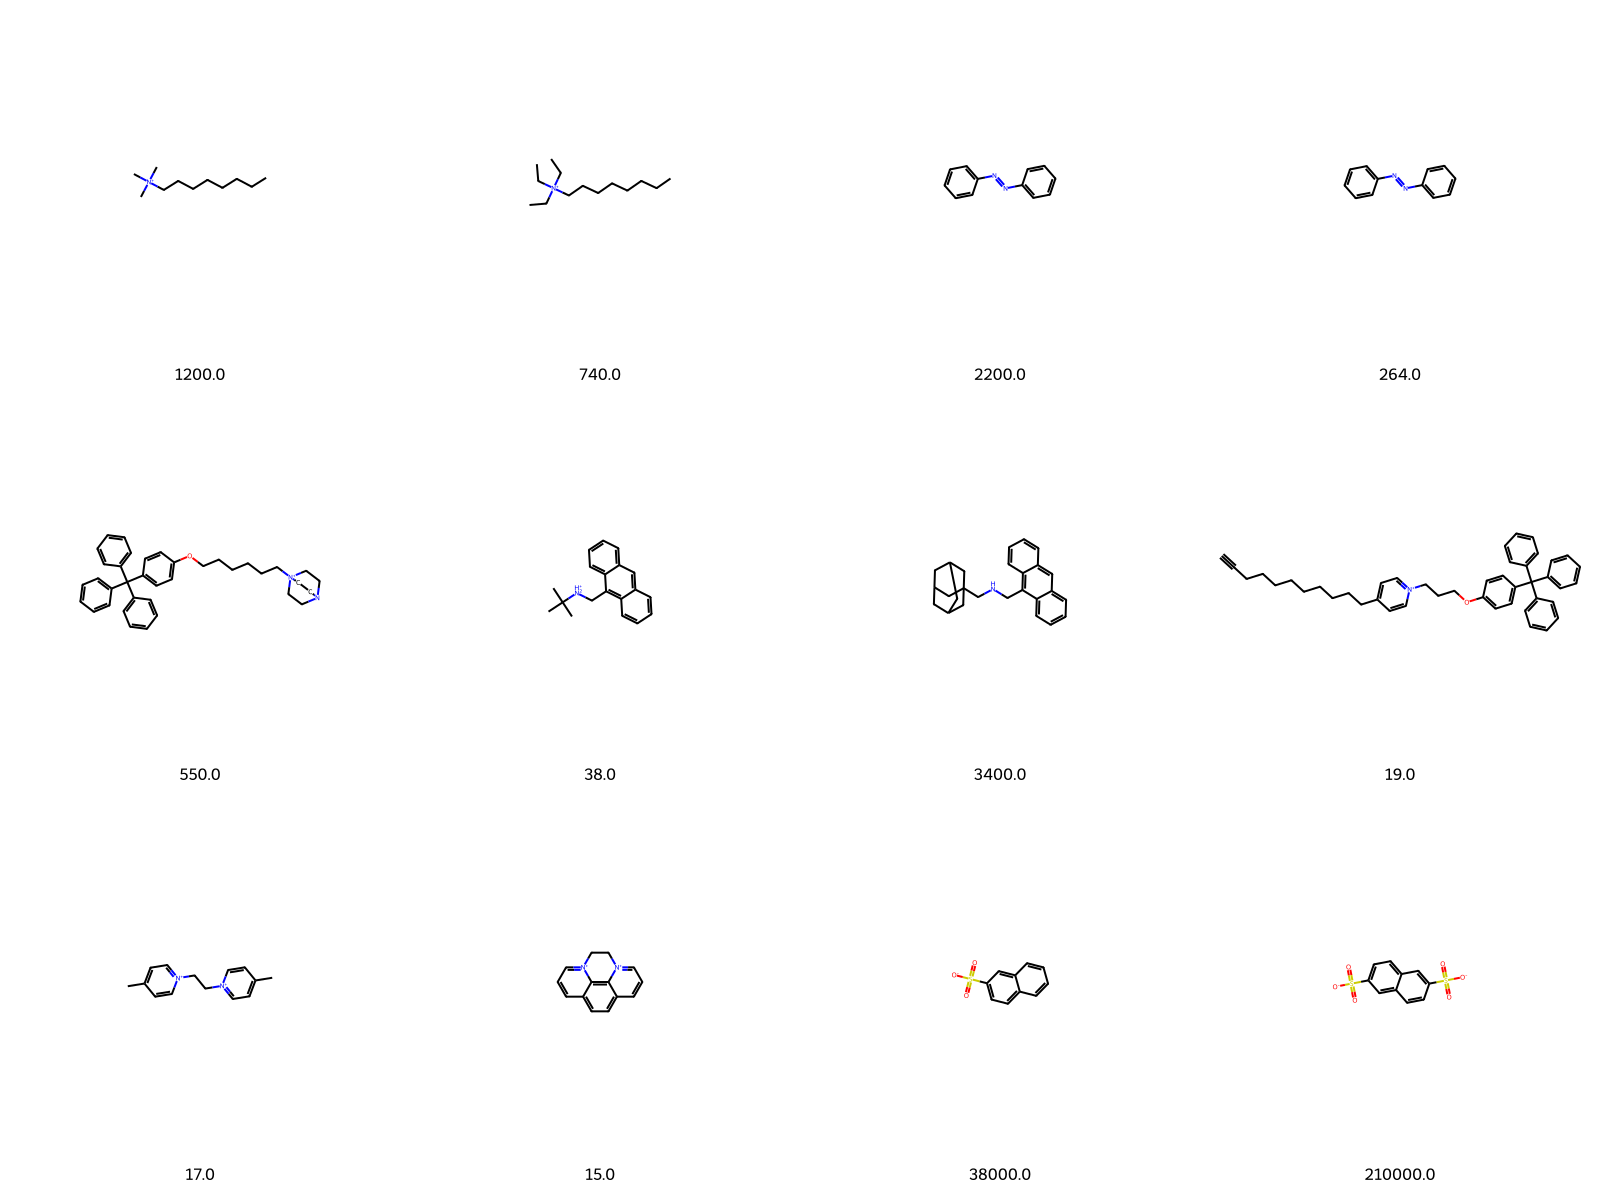

In [ ]:
#Визуализируем датасет
legends = [str(k) for k in part_add["Ka_mean"]]

Draw.MolsToGridImage(
    [Chem.MolFromSmiles(s) for s in part_add["Smiles"]],
    molsPerRow=4,
    subImgSize=(400, 400),
    legends=legends
)

### Хочу сохранить

Это функция, которая по SMILES определяет название молекулы по IUPAC

In [ ]:
!pip install pubchempy

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=1ba3b424f9c52182affa59ef5d86daced0989acfec89ba9efe8935f047fb0d12
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [ ]:
import pubchempy

# Use the SMILES you provided
smiles= "C1(C([N+]2=CC3)=C4C=3)[N+](CC2)=CC=CC=1C=C4"
compounds = pubchempy.get_compounds(smiles, namespace='smiles')
match = compounds[0]
print(match.iupac_name)

1,4-diazoniatetracyclo[6.6.2.04,16.011,15]hexadeca-1(14),4,6,8(16),9,11(15),12-heptaene


## Соединим данные

,Name,Smiles,Ka_mean,mol
0,cyclododecylammonium,[NH3+]C1CCCCCCCCCCC1,52000.0,
1,"4-(1,1-dimethylpiperidin-1-ium-4-yl)-1,1-dimet...",C[N+]1(C)CCC(CC1)C1CC[N+](C)(C)CC1,45000000.0,
2,norbornan-2-ylammonium,[NH3+]C1CC2CCC1C2,640000.0,
3,trimethylsilylmethylammonium,C[Si](C)(C)C[NH3+],500000.0,
4,"[3,5-dimethyl-7-(trimethylammonio)-1-adamantyl...",CC12CC3(C)CC(C1)(CC(C2)(C3)[N+](C)(C)C)[N+](C)...,9200.0,
5,cyclooctylammonium,[NH3+]C1CCCCCCC1,720000.0,
6,cyclohexylammonium,[NH3+]C1CCCCC1,130000.0,
7,3-[benzyl(dimethyl)ammonio]propane-1-sulfonate,C[N+](C)(CCCS([O-])(=O)=O)CC1=CC=CC=C1,23300.0,
8,(3-hydroxy-1-adamantyl)ammonium,[NH3+]C12CC3CC(C1)CC(O)(C3)C2,37000.0,
9,trimethyl-[[4-[(trimethylammonio)methyl]phenyl...,C[N+](C)(C)CC1=CC=C(C[N+](C)(C)C)C=C1,16000000.0,

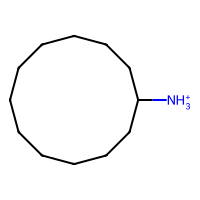
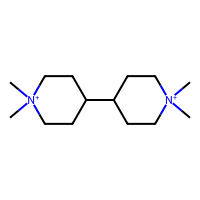
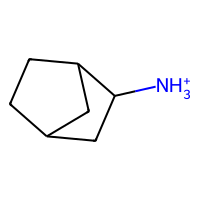
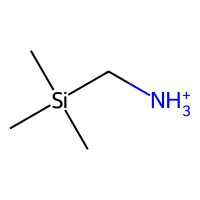
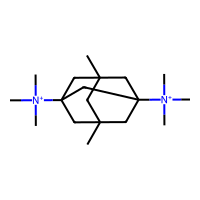
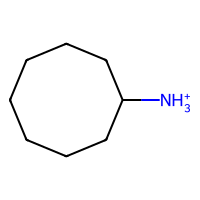
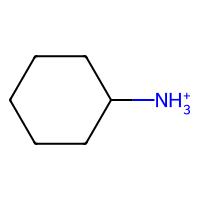
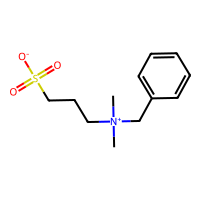
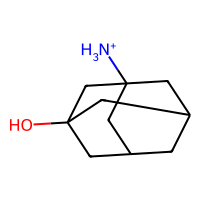
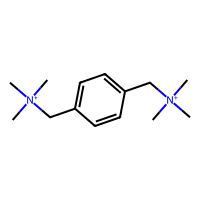
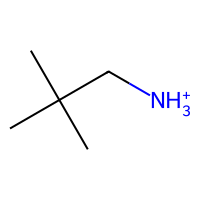
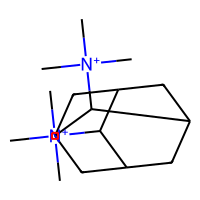
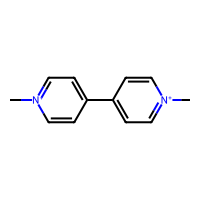
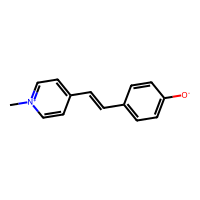
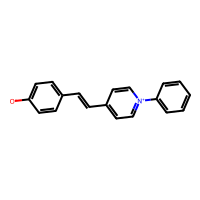
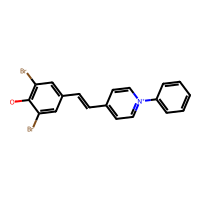
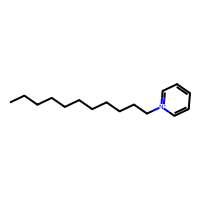
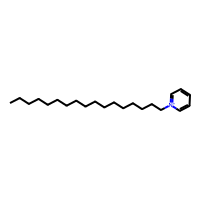
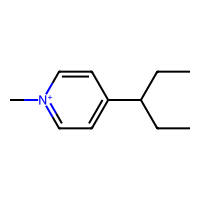
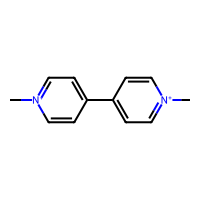
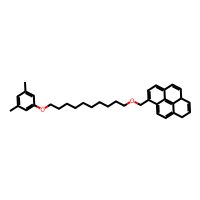

In [ ]:
FULL_df = pd.concat([part1, part2, part3], ignore_index = True)
PandasTools.AddMoleculeColumnToFrame(FULL_df, 'Smiles', 'mol')
FULL_df

,Name,Smiles,Ka_mean,mol
0,cyclododecylammonium,[NH3+]C1CCCCCCCCCCC1,52000.0,
1,"4-(1,1-dimethylpiperidin-1-ium-4-yl)-1,1-dimet...",C[N+]1(C)CCC(CC1)C1CC[N+](C)(C)CC1,45000000.0,
2,norbornan-2-ylammonium,[NH3+]C1CC2CCC1C2,640000.0,
3,trimethylsilylmethylammonium,C[Si](C)(C)C[NH3+],500000.0,
4,"[3,5-dimethyl-7-(trimethylammonio)-1-adamantyl...",CC12CC3(C)CC(C1)(CC(C2)(C3)[N+](C)(C)C)[N+](C)...,9200.0,
5,cyclooctylammonium,[NH3+]C1CCCCCCC1,720000.0,
6,cyclohexylammonium,[NH3+]C1CCCCC1,130000.0,
7,3-[benzyl(dimethyl)ammonio]propane-1-sulfonate,C[N+](C)(CCCS([O-])(=O)=O)CC1=CC=CC=C1,23300.0,
8,(3-hydroxy-1-adamantyl)ammonium,[NH3+]C12CC3CC(C1)CC(O)(C3)C2,37000.0,
9,trimethyl-[[4-[(trimethylammonio)methyl]phenyl...,C[N+](C)(C)CC1=CC=C(C[N+](C)(C)C)C=C1,16000000.0,

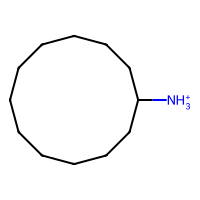
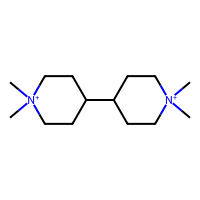
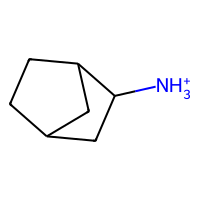
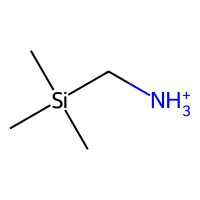
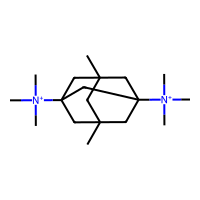
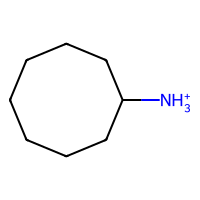
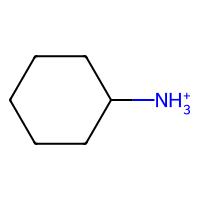
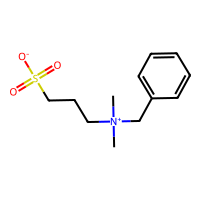
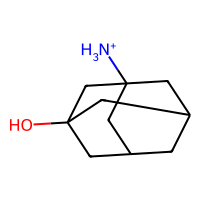
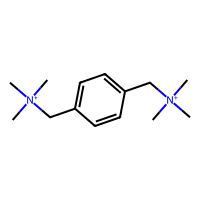
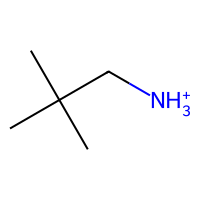
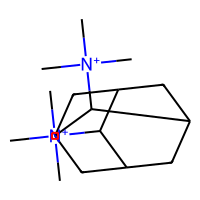
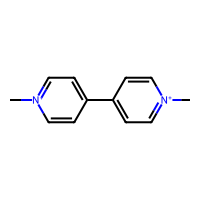
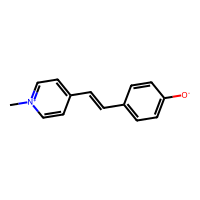
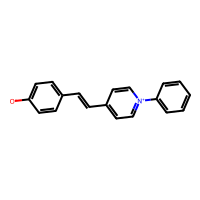
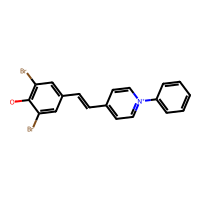
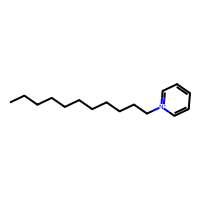
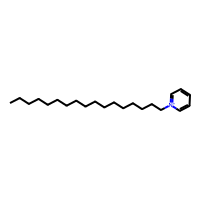
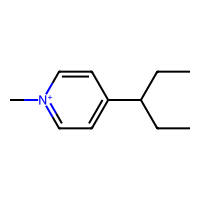
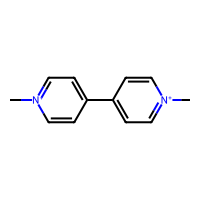
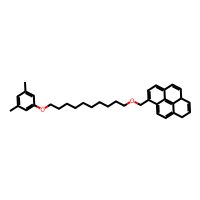
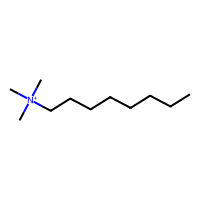
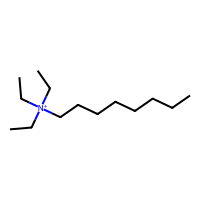
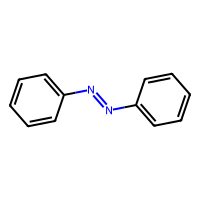
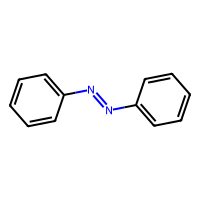
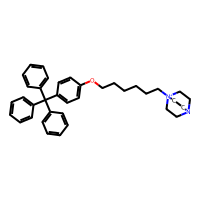
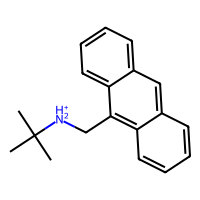
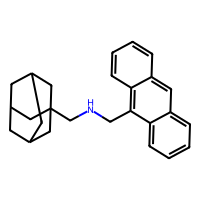
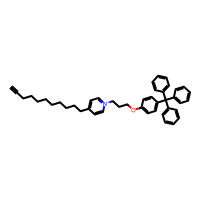
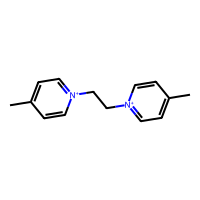
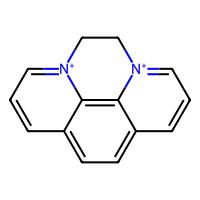
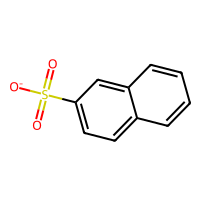
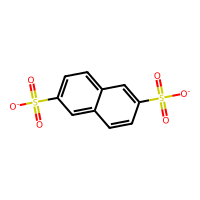

In [ ]:
FULL_df_add = pd.concat([FULL_df, part_add], ignore_index = True)
PandasTools.AddMoleculeColumnToFrame(FULL_df_add, 'Smiles', 'mol')
FULL_df_add

### Сохраним полные датасеты

In [ ]:
FULL_df.to_csv("GuestsWP6.csv")
FULL_df_add.to_csv("GuestsWP++.csv")